# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import librosa
import wave
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop

# Load the dataset

In [12]:
def extract_mfcc(wave_file_name):
    y, sr = librosa.load(wave_file_name)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [13]:
import concurrent.futures
import os

ravedess_speech_labels = []
ravedess_speech_data = []

def process_file(file_path, label):
    features = extract_mfcc(file_path)
    if features is not None:
        return label, features
    return None

# Use a ThreadPoolExecutor to parallelize the file processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for dirname, _, filenames in os.walk('/kaggle/input/ravdess-emotional-speech-audio'):
        for filename in filenames:
            if filename.endswith('.wav'):  # Process only .wav files
                label = int(filename[7:8]) - 1
                file_path = os.path.join(dirname, filename)
                futures.append(executor.submit(process_file, file_path, label))

    # Process the results as they come in
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result:
            ravedess_speech_labels.append(result[0])
            ravedess_speech_data.append(result[1])

print("Finish loading the dataset")

Finish loading the dataset


In [14]:
ravedess_speech_data

[array([-6.3554272e+02,  7.8015678e+01,  1.0508267e+01,  1.6849632e+01,
         1.2388647e+01, -1.1890794e+00,  2.3835747e+00, -5.8392096e+00,
        -5.2632799e+00,  7.4504626e-01,  2.8218639e+00, -1.3847197e+00,
         8.4464675e-01,  3.8793497e+00, -6.5802145e-01, -1.5619596e+00,
        -2.6697590e+00,  7.7843779e-01, -1.3205405e+00, -1.4132847e+00,
        -4.2303553e+00,  1.4454217e+00, -4.6674824e+00, -3.1218796e+00,
        -2.1456301e+00, -1.1103587e+00, -2.6859162e+00, -6.1717576e-01,
        -1.3109952e+00,  1.0287737e+00, -1.6633353e+00, -2.0847740e+00,
        -2.3108783e+00, -1.4272357e+00, -2.5259151e+00, -3.7337503e-01,
        -3.0181477e+00, -1.6511027e+00, -3.2324355e+00, -1.3072764e+00],
       dtype=float32),
 array([-5.8082275e+02,  6.8281700e+01, -2.3444453e-01,  1.3090450e+01,
         4.1463223e+00, -9.6438808e+00,  5.4440528e-01, -6.6995726e+00,
        -5.5980430e+00, -1.4942651e+00,  6.8736613e-01,  1.5369973e+00,
        -3.6222155e+00,  2.0236537e+00, 

In [15]:
ravedess_speech_data_array = np.asarray(ravedess_speech_data)
ravedess_speech_labels_array = np.array(ravedess_speech_labels)
ravedess_speech_data_array.shape

labels_categorical=to_categorical(ravedess_speech_labels_array)
labels_categorical.shape

(2880, 8)

In [16]:
ravedess_speech_data_array.shape

(2880, 40)

In [18]:
x_tarin,x_test,y_train,y_test=train_test_split(np.array(ravedess_speech_data_array),labels_categorical,test_size=0.20,random_state=9)

In [19]:
number_of_samples = ravedess_speech_data_array.shape[0]
training_samples = int(number_of_samples * 0.8)
validation_samples = int(number_of_samples * 0.1)
test_samples = int(number_of_samples * 0.1)

# Define LSTM Model

In [20]:
def create_model_LSTM():
  model = Sequential()
  model.add(LSTM(128, return_sequences=False, input_shape=(40, 1)))
  model.add(Dropout(0.5))
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.4))
  model.add(Dense(32))
  model.add(Activation('relu'))
  model.add(Dense(8))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
  return model

In [21]:
w=np.expand_dims(ravedess_speech_data_array[:training_samples],-1)

In [22]:
w.shape

(2304, 40, 1)

In [23]:
model_A = create_model_LSTM()  # Create the LSTM model
history = model_A.fit(np.expand_dims(ravedess_speech_data_array[:training_samples], -1), labels_categorical[:training_samples], validation_data=(np.expand_dims(ravedess_speech_data_array[training_samples:training_samples+validation_samples], -1), labels_categorical[training_samples:training_samples+validation_samples]), epochs=130, shuffle=True)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1334 - loss: 2.0812 - val_accuracy: 0.1806 - val_loss: 2.0241
Epoch 2/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1696 - loss: 2.0192 - val_accuracy: 0.2257 - val_loss: 1.9515
Epoch 3/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2433 - loss: 1.9428 - val_accuracy: 0.2535 - val_loss: 1.9221
Epoch 4/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2670 - loss: 1.8620 - val_accuracy: 0.2396 - val_loss: 1.9139
Epoch 5/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2758 - loss: 1.8639 - val_accuracy: 0.2639 - val_loss: 1.8908
Epoch 6/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3114 - loss: 1.8021 - val_accuracy: 0.2708 - val_loss: 1.8807
Epoch 7/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3122 - loss: 1.7921 - val_accuracy: 0.2778 - val_loss: 1.8905
Epoch 8/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3090 - loss: 1.7507 - val_accuracy: 0.2465 - v

# Model Evaluation

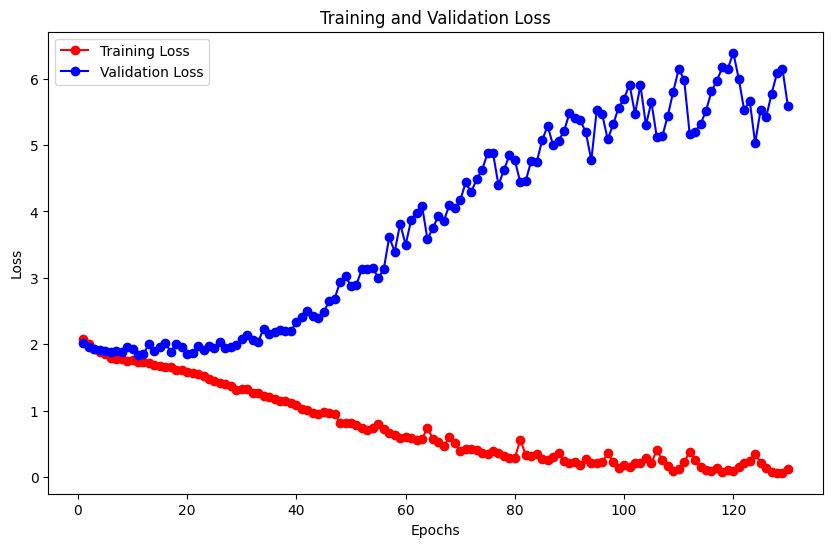

In [35]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'bo-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training and Validation Accuracy


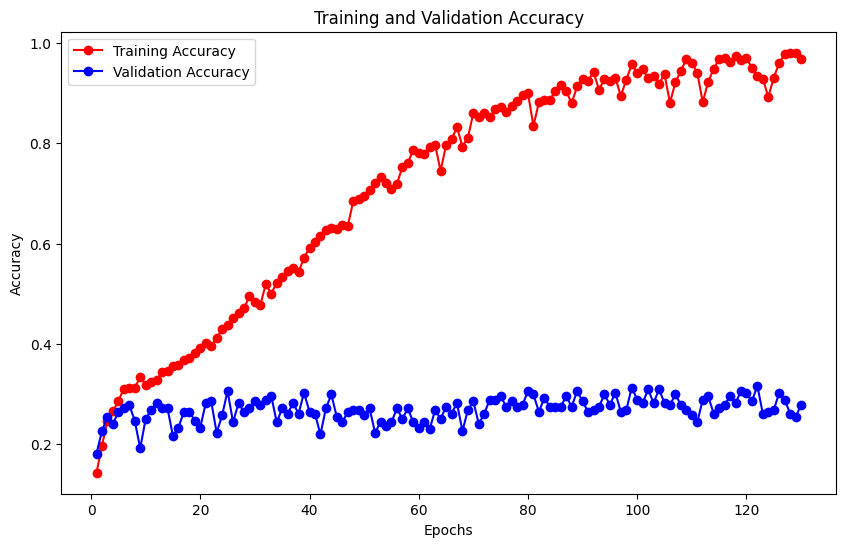

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'ro-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'bo-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
model_A = create_model_LSTM()  # Create the LSTM model

In [26]:
model_A.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,482 (904.23 KB)

 Trainable params: 77,160 (301.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 154,322 (602.82 KB)

In [27]:
# Define emotion mapping
emotions = {
    1: "neutral",
    2: "calm",
    3: "happy",
    4: "sad",
    5: "angry",
    6: "fearful",
    7: "disgust",
    8: "surprised"
}

def predict(wave_filepath):
    """
    Predict the emotion from a given wave file.

    :param wave_filepath: Path to the .wav file to predict.
    """
    try:
        # Extract MFCC features from the wave file
        test_point = extract_mfcc(wave_filepath)
        if test_point is None:
            print(f"Failed to extract features from {wave_filepath}")
            return

        # Reshape the feature vector to match the model input
        test_point = np.reshape(test_point, newshape=(1, 40, 1))

        # Make predictions using the trained model
        predictions = model_A.predict(test_point)

        # Get the emotion with the highest prediction probability
        predicted_emotion = emotions[np.argmax(predictions[0]) + 1]
        print(f"Predicted Emotion: {predicted_emotion}")
    except Exception as e:
        print(f"Error in prediction: {e}")

In [33]:
predict('/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-06-02-02-01-01.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Emotion: fearful


In [34]:
predict ('/kaggle/input/ravdess-emotional-speech-audio/Actor_15/03-01-01-01-01-01-15.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Emotion: neutral


In [31]:
predict ('/kaggle/input/ravdess-emotional-speech-audio/Actor_14/03-01-03-01-01-01-14.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Emotion: angry


# Save the model

In [36]:
import pickle


model =  model_A

# Path to save the .pkl file
model_path = "trained_model.pkl"

# Save the trained model
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved to {model_path}")

Model saved to trained_model.pkl
